### IDEAL SHAPE MEASURES 

from [esda.shape](https://pysal.org/esda/_modules/esda/shape.html#equivalent_rectangular_index)

*excluded: length_width_diff, fractal_dimension, squareness*

* `isp` **isoperimetric_quotient** defined as the ratio of a polygon's area to the area of the equi-perimeter circle
* `isa` **isoareal_quotient** ratio of a geometry's perimeter to the perimeter of the equi-areal circle
* `min` **minimum bounding circle ratio**  The Reock compactness measure, defined by the ratio of areas between the minimum bounding/containing circle of a shape and the shape itself. **aka circular compactness!**
* `rad` **radii ratio** The ratio of the radius of the equi-areal circle to the radius of the MBC
* `bou` **boundary amplitude**  length of the boundary of the convex hull divided by the length of the boundary of the original shape
* `dia` **diameter ratio** It is given as the ratio between the minimum and maximum shape diameter.
* `con` **convex hull ratio** ratio of the area of the convex hull to the area of the shape itself
* `rec` **rectangularity** Ratio of the area of the shape to the area of its minimum bounding rotated rectangle (reveals a geometry's degree of being curved inward)
* `sha` **shape index**   Schumm’s shape index (Schumm (1956) in MacEachren 1985) (sqrt(A) / pi) /  R,   where A is the area and R is the radius of the minimum bounding circle.
* `equ` **equivalent rectangular index**     Deviation of a polygon from an equivalent rectangle *(sqrt(A)/AMBR) * (PMBR/P)* where A is the area, AMBR is the area of minimum bounding rotated rectangle, P is the perimeter, PMBR is the perimeter of the minimum bounding rotated rectangle.



In [443]:
# import libraries
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import esda.shape as es

from shapely.geometry import Polygon
from shapely.geometry import Point

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler

import folium

### Read in polygon data from all FUAs into gdf `apd`

In [444]:
sample = geopandas.read_parquet("../data/sample.parquet")

def makefua_gdf(myfua):
    myfua = int(myfua)
    gdf = geopandas.read_parquet(f"../data/{myfua}/polygons.parquet")
    gdf["fua"] = myfua
    gdf = gdf[["fua", "geometry", "area"]]
    return (gdf)

apd = pd.concat([makefua_gdf(fua) for fua in sample.eFUA_ID])
apd = apd.reset_index(drop = True)
apd.tail()

,fua,geometry,area
1039740,2345,"POLYGON ((553072.200 4253226.948, 553063.804 4...",300.050085
1039741,2345,"POLYGON ((564225.399 4243189.049, 564235.735 4...",1012.490224
1039742,2345,"POLYGON ((564202.025 4243177.189, 564201.058 4...",977.837497
1039743,2345,"POLYGON ((560790.727 4243019.053, 560769.085 4...",2195.430501
1039744,2345,"POLYGON ((565696.543 4236927.698, 565695.668 4...",173.045002


### Make a gdf `scd` with square and circle polygons (to compare parameter values) 

In [445]:
### Compute all parameters above for a square and a circle
sq = Polygon([(0,1),(1,1),(1,0),(0,0)])
ci = Point(0,0).buffer(1)
scd = geopandas.GeoDataFrame({"geometry": [sq, ci], "color": ["red", "green"]})
scd.index = ["sq", "ci"]

### Compute ESDA shape parameters (as listed above) for all polygons, both gdfs

In [20]:
# Variable names
vs = ["isp", "isa", "min", "rad", "bou", "dia", "con", "rec", "sha", "equ"]

# For square and circle:
scd["isp"] = es.isoperimetric_quotient(scd["geometry"])
scd["isa"] = es.isoareal_quotient(scd["geometry"])
scd["min"] = es.minimum_bounding_circle_ratio(scd["geometry"])
scd["rad"] = es.radii_ratio(scd["geometry"])
scd["bou"] = es.boundary_amplitude(scd["geometry"])
scd["dia"] = es.diameter_ratio(scd["geometry"])
scd["con"] = es.convex_hull_ratio(scd["geometry"])
scd["rec"] = es.rectangularity(scd["geometry"])
scd["sha"] = es.shape_index(scd["geometry"])
scd["equ"] = es.equivalent_rectangular_index(scd["geometry"])

# For actual street blocks:
apd["isp"] = es.isoperimetric_quotient(apd["geometry"])
apd["isa"] = es.isoareal_quotient(apd["geometry"])
apd["min"] = es.minimum_bounding_circle_ratio(apd["geometry"])
apd["rad"] = es.radii_ratio(apd["geometry"])
apd["bou"] = es.boundary_amplitude(apd["geometry"])
apd["dia"] = es.diameter_ratio(apd["geometry"])
apd["con"] = es.convex_hull_ratio(apd["geometry"])
apd["rec"] = es.rectangularity(apd["geometry"])
apd["sha"] = es.shape_index(apd["geometry"])
apd["equ"] = es.equivalent_rectangular_index(apd["geometry"])

In [28]:
# (too large to push to github)
# apd.to_pickle("../data/apd.pickle")
# apd.to_parquet("../data/apd.parquet")

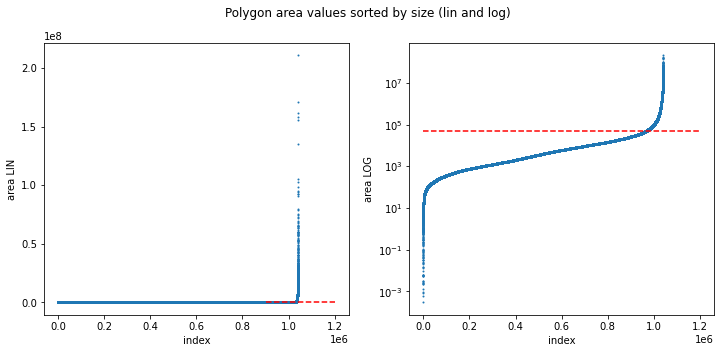

In [446]:
# OUTLIERS TO POTENTIALLY REMOVE

mycut = 5*10**4 # set cut off value

fig, ax = plt.subplots(1,2, figsize = (12,5))

# lin plot
ax[0].scatter(np.arange(len(apd)), sorted(apd["area"]), s = 1)
ax[0].set_xlabel("index")
ax[0].set_ylabel("area LIN")
ax[0].hlines(mycut, 0.9*10**6, 1.2*10**6, color = "red", linestyles="dashed")

# log plot
ax[1].scatter(np.arange(len(apd)), sorted(apd["area"]), s = 1)
ax[1].set_yscale("log")
ax[1].set_xlabel("index")
ax[1].set_ylabel("area LOG")
ax[1].hlines(mycut, 0, 1.2*10**6, color = "red", linestyles="dashed")

plt.suptitle("Polygon area values sorted by size (lin and log)");

In [447]:
apdo = apd.copy()
apdo = apdo[apdo["area"]<mycut].reset_index(drop=True)
print("Removed polygons with size > " + str(mycut))
print("Removed", np.round((1-len(apdo)/len(apd))*100, 1), "% of all polygons")
apdo.head(2)

Removed polygons with size > 50000
Removed 7.1 % of all polygons


,fua,geometry,area
0,965,"POLYGON ((347115.426 141832.171, 347054.240 14...",40559.488627
1,965,"POLYGON ((347054.240 141782.584, 347115.426 14...",25288.644598


`apd`: all polygons data frame

`apdo`: all polygons data frame with outliers (size > 50.000) removed

In [190]:
plt.ioff()

myxlim = (-100, 5*10**4)

for myparam in vs:
    
    fig, ax = plt.subplots(1,1)

    apdo.plot.scatter(
        ax = ax,
        x = "area", 
        y = myparam, 
        figsize=(20, 20), 
        s=.002, 
        label = "All polygons < " + str(mycut))

    for b in ["sq", "ci"]:
        ax.hlines(
            y = scd.loc[b, myparam], 
            xmin = myxlim[0], 
            xmax = myxlim[1], 
            color = scd.loc[b, "color"], 
            linestyles="dashed", 
            alpha = 0.5, 
            label = b)

    ax.set_xlim(myxlim)

    ax.legend();

    plt.tight_layout()

    fig.savefig("../plots/params/area_vs_" + myparam + ".png", dpi = 400)

    plt.close()

***************
## TRY: some combination of perimeter and area?

try for one of the bigger cities: 
order polygons by length/area ratio; 
the smaller the ratio, the lengthier the polygon

In [ ]:
# coldict = {
#     1: "red",
#     2: "blue",
#     3: "orange",
#     4: "yellow",
#     5: "brown",
#     6: "pink",
#     7: "black",
#     8: "green",
#     9: "purple",
#     0: "grey"
# }

#### Vitoria-Gasteiz
* `lar`: length-area-ratio
* `ar`: square root of area
* `arnorm`: ratio of ar (square root of area) and length
* `reock`: esda.min... = circular compactness

In [426]:
# vitoria-gasteiz
vg = apd[apd["fua"]==3583].copy().reset_index(drop=True)
vg.crs = "EPSG:3042"

vg["length"] = vg.apply(lambda x: x.geometry.length, axis = 1)

vg["lar"] = vg["length"]/vg["area"] 
vg["ar"] = np.sqrt(vg["area"])
vg["arnorm"] =  vg["ar"] / vg["length"]

vg["reock"] = es.minimum_bounding_circle_ratio(vg)

vg.sort_values(by = "area", inplace = True)
vg = vg.reset_index(drop=True)

# for folium plotting: convert to epsg4326
vg = vg.to_crs("epsg:4326")

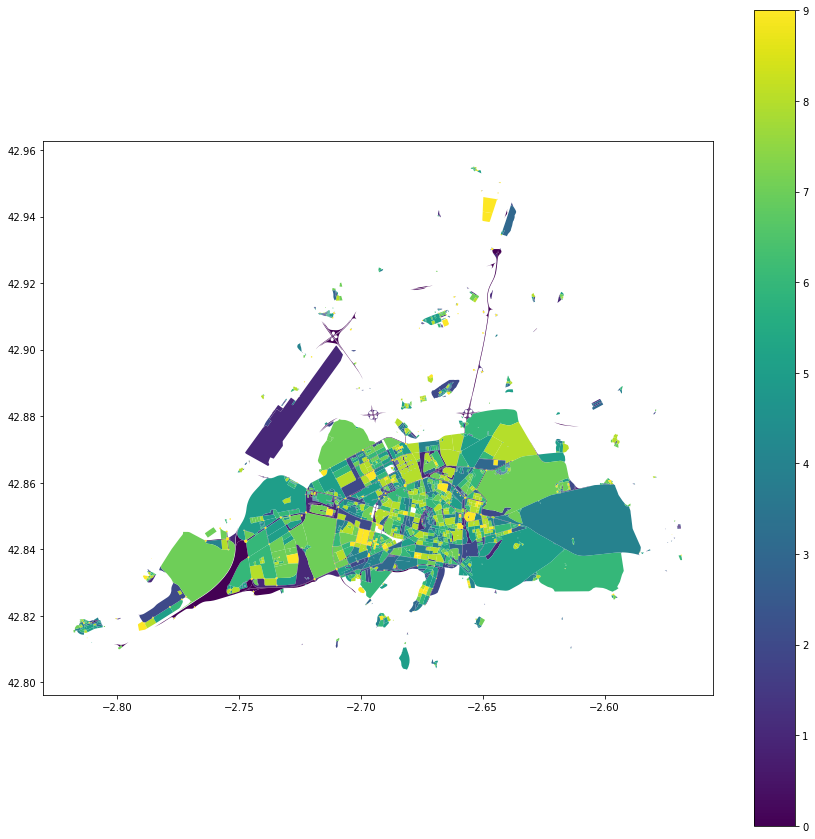

In [432]:
# binning in 10% quantiles by reock value
edges = np.quantile(vg["reock"], np.arange(0.1,1.1,0.1))
edges[-1] = edges[-1]*1.001
vg["bin"] = vg.apply(lambda x: np.where(edges>x.reock)[0][0], axis = 1)
vg.plot(column = "bin", legend = True, figsize = (15,15));

<AxesSubplot:>

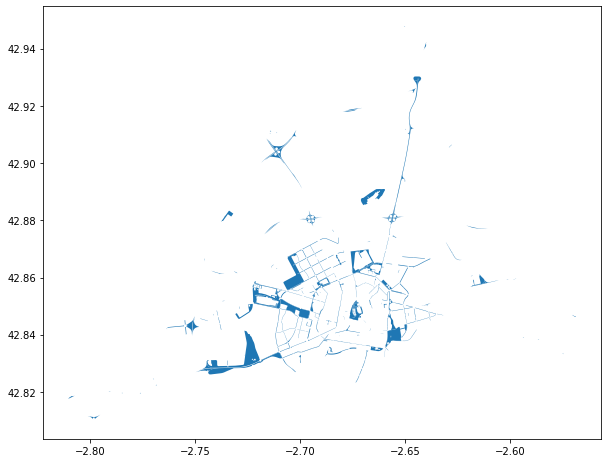

In [425]:
vg[(vg["reock"]<0.3) & (vg["arnorm"]<0.15) & (vg["area"]<10**6)].plot(figsize = (10,10))

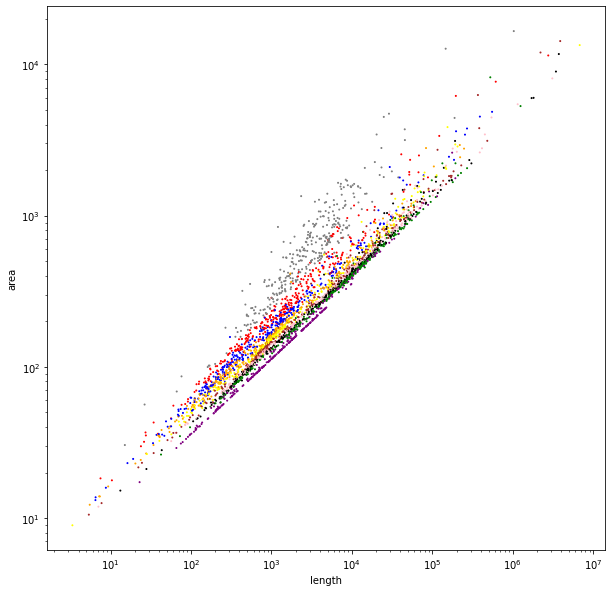

In [437]:
# Colors: 10% quantiles of reock values
# --> similar values of length-area-ratio!
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(vg["area"], vg["length"], color = vg["color"], s = 1)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("length")
ax.set_ylabel("area");

In [295]:
folium_layers = {
    'Google Satellite': folium.TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = True,
            control = True
            ),
    'OSM': folium.TileLayer(
            tiles = "openstreetmap", 
            name = "OpenStreetMap",
            control = True, 
            overlay = True
            ),
    'whiteback': folium.TileLayer(
            tiles = 'https://api.mapbox.com/styles/v1/krktalilu/ckrdjkf0r2jt217qyoai4ndws/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1Ijoia3JrdGFsaWx1IiwiYSI6ImNrcmRqMXdycTB3NG8yb3BlcGpiM2JkczUifQ.gEfOn5ttzfH5BQTjqXMs3w',
            name = "Background: White",
            attr = 'Mapbox',
            control = True,
            overlay = True
            )
}

# Folium plot 
polygons below/above filter values for:
* area (min & max)
* reock (max)
* arnorm (max)

In [438]:
area_cut_big = 10**6
area_cut_small = 10**2
reock_cut = 0.3
arnorm_cut = 0.15

m = folium.Map(location=[42.847, -2.6714], zoom_start=13, tiles=None)

folium_layers["OSM"].add_to(m)

vgf = vg[(vg["area"]>area_cut_small)&(vg["area"]<area_cut_big)]

vgf1 = vgf[(vgf["reock"]<reock_cut)&(vgf["arnorm"]<arnorm_cut)]
vgf2 = vgf[(vgf["reock"]>reock_cut)&(vgf["arnorm"]>arnorm_cut)]
vgf3 = vgf[(vgf["reock"]<reock_cut)&(vgf["arnorm"]>arnorm_cut)]
vgf4 = vgf[(vgf["reock"]>reock_cut)&(vgf["arnorm"]<arnorm_cut)]

fg1 = folium.FeatureGroup(name = "below both", show = False)
fg2 = folium.FeatureGroup(name = "above both", show = False)
fg3 = folium.FeatureGroup(name = "arnorm filtered out", show = False)
fg4 = folium.FeatureGroup(name = "reock filtered out", show = False)
fg5 = folium.FeatureGroup(name = "big filtered out", show = False)
fg6 = folium.FeatureGroup(name = "small filtered out", show = False)

for _, r in vgf1.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'red', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg1)

for _, r in vgf2.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'black', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg2)

for _, r in vgf3.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'blue', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg3)

for _, r in vgf4.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg4)

for _, r in vg[vg["area"]>area_cut_big].iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'grey', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg5)

for _, r in vg[vg["area"]<area_cut_small].iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'orange', 'fillOpacity': 0.9, 'weight': 1})
    geo_j.add_to(fg6)

fg1.add_to(m)
fg2.add_to(m)
fg3.add_to(m)
fg4.add_to(m)
fg5.add_to(m)
fg6.add_to(m)

folium.LayerControl().add_to(m)

m.save("../plots/vitoria_6.html")

***********

In [449]:
area_cut = 10**4
reock_cut = 0.3

m = folium.Map(location=[42.847, -2.6714], zoom_start=13, tiles=None)

folium_layers["OSM"].add_to(m)

vgf = vg.copy()

vgf1 = vgf[(vgf["reock"]<reock_cut)&(vgf["area"]<area_cut)]
vgf2 = vgf[(vgf["reock"]>reock_cut)&(vgf["area"]>area_cut)]
vgf3 = vgf[(vgf["reock"]<reock_cut)&(vgf["area"]>area_cut)]
vgf4 = vgf[(vgf["reock"]>reock_cut)&(vgf["area"]<area_cut)]

fg1 = folium.FeatureGroup(name = "below both", show = False)
fg2 = folium.FeatureGroup(name = "above both", show = False)
fg3 = folium.FeatureGroup(name = "area>1000 filtered out", show = False)
fg4 = folium.FeatureGroup(name = "reock>0.3 filtered out", show = False)

for _, r in vgf1.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'red', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg1)

for _, r in vgf2.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'black', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg2)

for _, r in vgf3.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'blue', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg3)

for _, r in vgf4.iterrows():
    sim_geo = geopandas.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                        style_function=lambda x: {'fillColor': 'green', 'fillOpacity': 0.9, 'weight': 0})
    geo_j.add_to(fg4)

fg1.add_to(m)
fg2.add_to(m)
fg3.add_to(m)
fg4.add_to(m)

folium.LayerControl().add_to(m)

m.save("../plots/vitoria_4.html")

***************
## PREP FOR DBSCAN EXPERIMENTS

/var/folders/b0/lkvf88hn0673f5dlj9z0_2dr0000gn/T/ipykernel_10622/2707475032.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(" ");


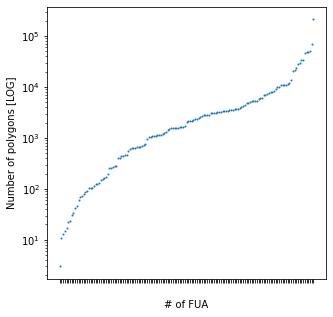

In [439]:
# number of polygons per city:
fuas = np.unique(apd["fua"])
lens = pd.DataFrame({ "fua": fuas})
lens["cityname"] = lens.apply(
    lambda x: sample.loc[sample[sample["eFUA_ID"]==x.fua].index[0], "eFUA_name"], axis = 1)
lens["N"] = lens.apply(lambda x: len(apd[apd["fua"]==x.fua]), axis = 1)
lens = lens.sort_values(by = "N").reset_index(drop = True)
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.scatter([str(fua) for fua in lens["fua"]], lens["N"], s = 1)
ax.set_xlabel("# of FUA")
ax.set_ylabel("Number of polygons [LOG]")
ax.set_xticklabels(" ");
ax.set_yscale("log");

In [440]:
# Cities with less than 100 polygons
lens[lens["N"]<100]

,fua,cityname,N
0,6228,Shawan,3
1,3461,Awbere,11
2,1225,Kimbe,13
3,2426,Chuadanga,15
4,7355,Shahpur,17
5,3873,Shambu,22
6,2225,Gemena,23
7,605,Goroka,31
8,8582,Jingzhou,33
9,1115,Alotau,42


<AxesSubplot:>

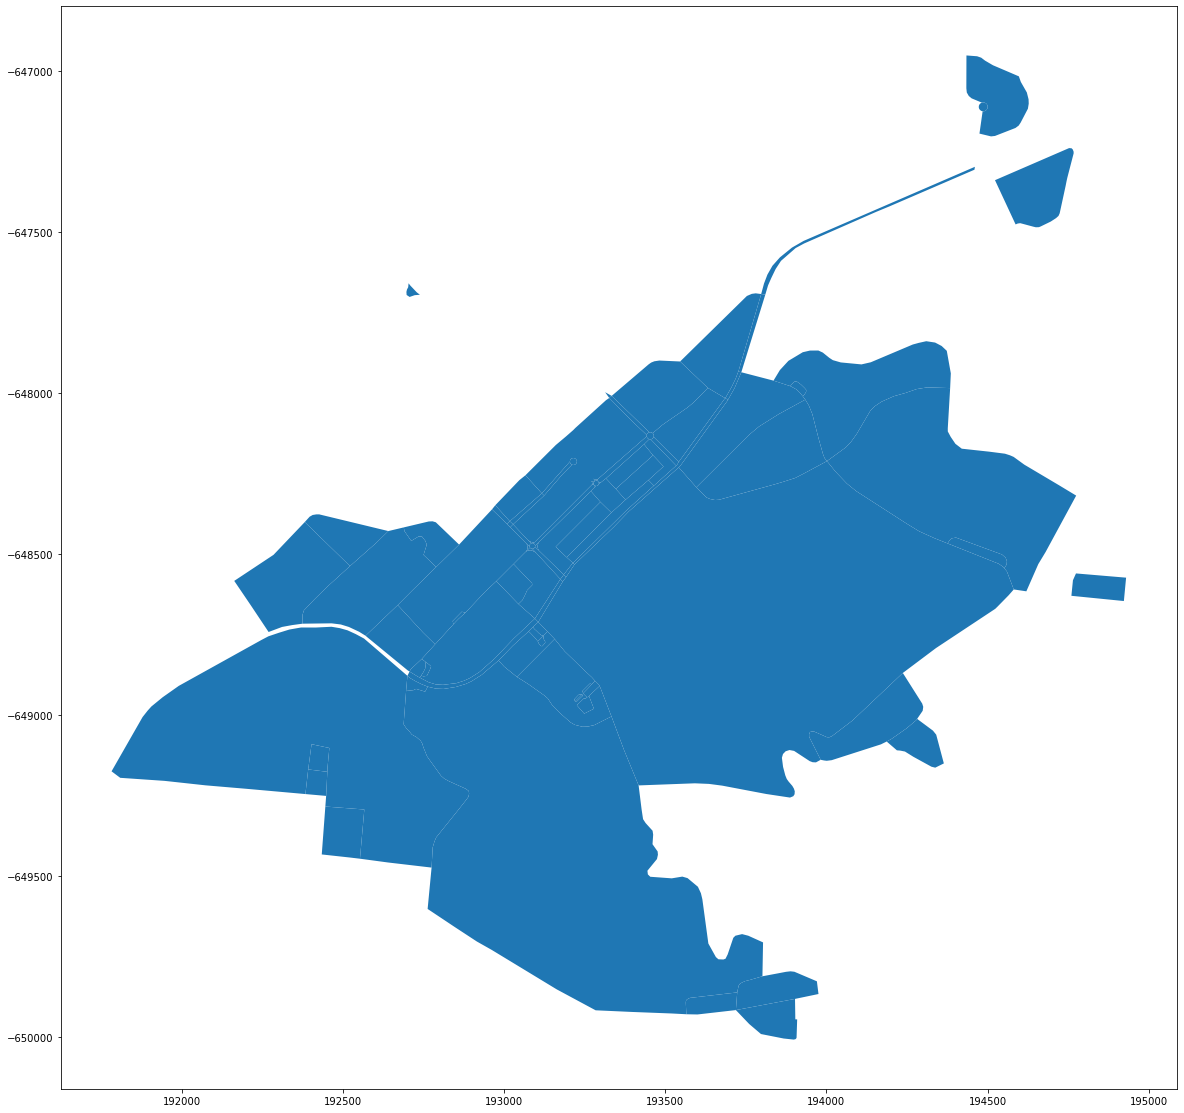

In [441]:
# Mount Hagen: the smallest one to keep (N=90)
apd[apd["fua"]==306].plot(figsize = (20,20))

In [448]:
apdos = apdo[apdo["fua"].isin(lens[lens["N"]>=90]["fua"])].copy().reset_index(drop=True)

`apdos`: removed all polygons with size > 50.000; removed all cities with polygon number < 90

In [ ]:
# Make dict to store results from all DBScans

myparam = "min"
res_min = dict()

fuas = np.unique(apdos["fua"])

for myfua in fuas:
    res_min[myfua] = {}
    cityname = sample.loc[sample[sample["eFUA_ID"]==myfua].index[0], "eFUA_name"]
    city = apdos[apdos["fua"]==myfua]
    city.reset_index(drop = True, inplace = True)
    data = city[["area", myparam]]

    scaler_cent = RobustScaler(with_centering = True)
    scaler_nocent = RobustScaler(with_centering = False)

    scaled1 = scaler_cent.fit_transform(data)
    scaled2 = scaler_nocent.fit_transform(data)

    scaled1df = pd.DataFrame(scaled1, columns = ["area", myparam])
    scaled2df = pd.DataFrame(scaled2, columns = ["area", myparam])

    # plot scaling results
    plt.ioff()

    fig, ax = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)

    ax[0].scatter(
        x = scaled1df["area"], 
        y = scaled1df[myparam], 
        s=.1)
    ax[0].set_title("Scaled with centering")
    ax[0].set_xlabel("area")
    ax[0].set_ylabel(myparam)

    ax[1].scatter(
        x = scaled2df["area"], 
        y = scaled2df[myparam], 
        s=.1)
    ax[1].set_title("Scaled without centering")

    plt.suptitle("Scaling area vs " + myparam +  " for " + cityname + ", N=" + str(len(city)));
    plt.tight_layout()

    fig.savefig(f"../plots/scaling/{myfua}.png")

    plt.close()

    # save results to dict with fua as key:
    res_min[myfua]["cityname"] = cityname
    res_min[myfua]["scaled1"] = scaled1
    res_min[myfua]["scaled2"] = scaled2
    res_min[myfua]["scaled1df"] = scaled1df
    res_min[myfua]["scaled2df"] = scaled2df

In [197]:
### run DBSCAN for Reock for several cities

# list of all cities
fuas = np.unique(apdo["fua"])

# set city
myfua = fuas[0]

# print city name
cityname = sample.loc[sample[sample["eFUA_ID"]==myfua].index[0], "eFUA_name"]
print(cityname)

# set param
myparam = "min" 
city = apdo[apdo["fua"]==myfua]
city.reset_index(drop = True, inplace = True)
data = city[["area", myparam]]

Mandurah


In [99]:
scaler_cent = RobustScaler(with_centering = True)
scaler_nocent = RobustScaler(with_centering = False)

scaled1 = scaler_cent.fit_transform(data)
scaled2 = scaler_nocent.fit_transform(data)

scaled1df = pd.DataFrame(scaled1, columns = ["area", myparam])
scaled2df = pd.DataFrame(scaled2, columns = ["area", myparam])

In [116]:
plt.ioff()

fig, ax = plt.subplots(1, 2, figsize = (10,5), sharex = True, sharey = True)

ax[0].scatter(
    x = scaled1df["area"], 
    y = scaled1df[myparam], 
    s=.1)
ax[0].set_title("Scaled with centering")
ax[0].set_xlabel("area")
ax[0].set_ylabel(myparam)

ax[1].scatter(
    x = scaled2df["area"], 
    y = scaled2df[myparam], 
    s=.1)
ax[1].set_title("Scaled without centering")

plt.suptitle("Scaling area vs " + myparam +  " for " + cityname + ", N=" + str(len(city)));
plt.tight_layout()

fig.savefig(f"../plots/scaling/{myfua}.png")

plt.close()

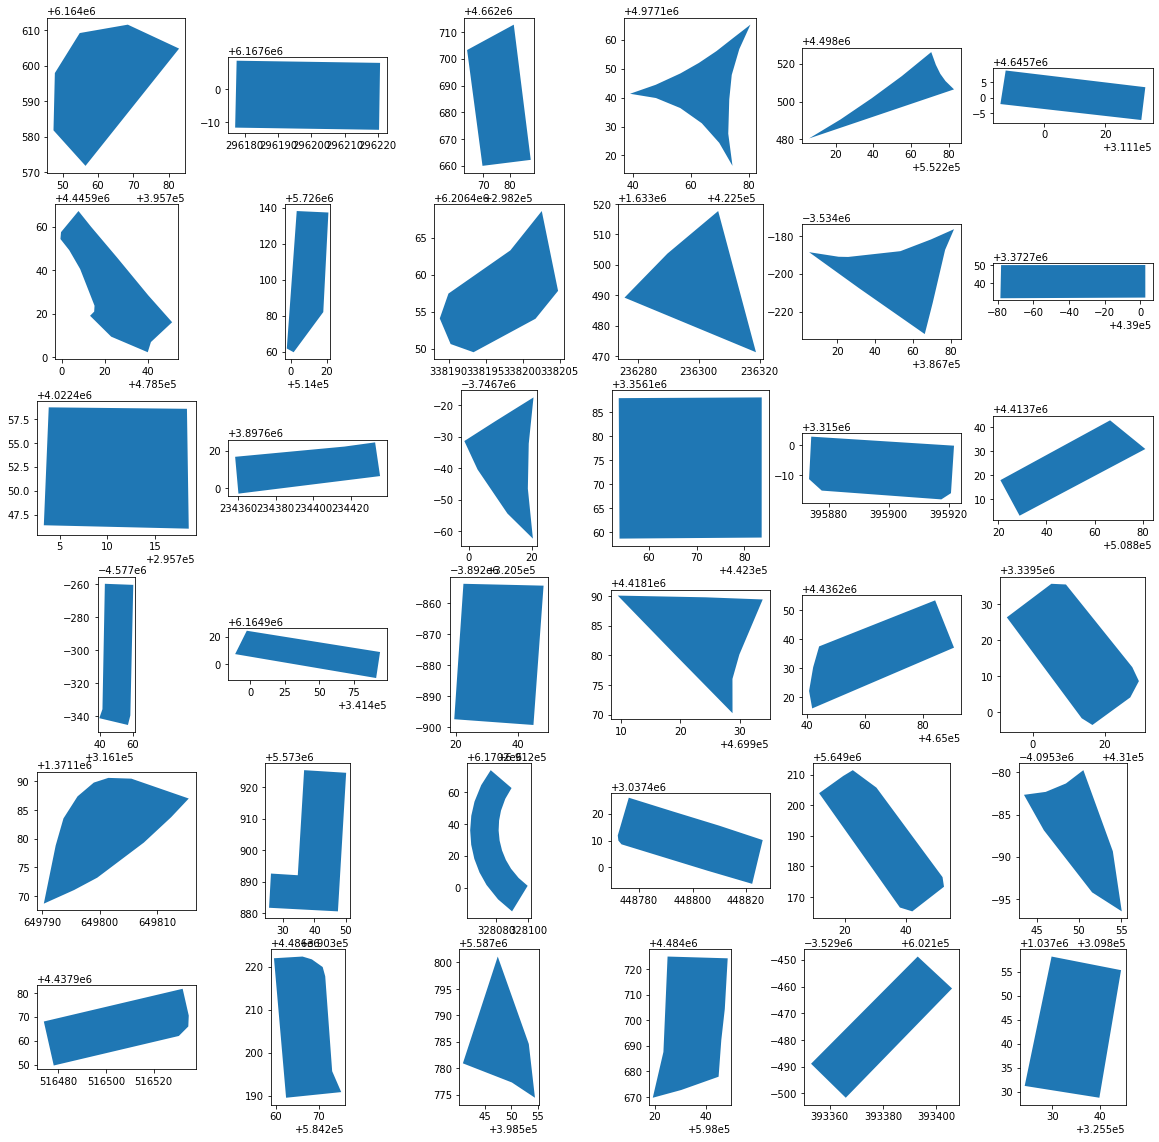

In [63]:
# si = 6
# imax = si**2

# mypls = data[db.labels_ == 0].index[0:imax]
# myin = [i for i in np.ndindex(si,si)]

# fig, ax = plt.subplots(
#     si,si, 
#     figsize = (20,20), 
#     sharex=False, 
#     sharey=False)

# for i in range(imax):
#     data[data.index == mypls[i]].plot(ax = ax[myin[i]])
